In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Goal of this module 

1. Understand the importance of the Riemann problem as solution of hyperbolic system in general and for the Euler equations in particular
2. Understand how the different bits and pieces of a full fluid code fit together, i.e. how it differs (or not differ) from linear advection and Burger's equation
3. Be able to implement them or to be more precise: Be able to numerically solve the shock tube problem with a second order MUSCL-Hancock scheme that includes 
 - piecewise linear reconstruction with slope limitting (beta limiter: minmod/superbee)
 - an approximate Riemann solver (HLL)
4. Bonus (for free): Read, understand and extend someone else's code


# Preclass assignments

## Reading

First, get the (quite exhaustive) "introduction" 
*Riemann Solvers and Numerical Methods for Fluid Dynamics A Practical Introduction* by Eleuterio F. Toro
at http://link.springer.com/978-3-540-49834-6 (access from within MSU network or via proxy).

Side note: You can get actual print copies of all springer books (that are available as ebooks on link.springer.com) for just 25 USD. 

For this module I prefer this resource for its modularity and accessibility (if you read the text carefully).
As you'll see, a lot of general ideas are repeated and cross referenced in the beginning of chapters/section,
which helps to put previous ideas in light of the current concept.

### General background
Read 
- 1.1 Introduction/recap to the Euler equations (3p)
- 1.2.2 Equation of state (1p)
- 4.0 and 4.1 General solution strategy for the Riemann problem for the Euler eqns (4p)

### Background for the implementation below
You'll implement parts of the schemes presented in the following (sub)sections.
I added the corresponding equations numbers for reference in the code (which is always a good idea).

Read
- 10.1, 10.2 and 10.3 HLL Riemann solver (7p)
- 10.5.0 and 10.5.1 Wave speed estimation (2p)
- 14.1 Introduction/recap to High–Order and TVD Schemes for Non–Linear Systems (2p)
- 14.2 CFL and Boundary Conditions (1p)
- 14.4.1 The MUSCL–Hancock Scheme (basics) (3p)
- 14.4.3 TVD Version of the Scheme (i.e. slope limiting) (3p)
- 14.4.4 Summary of the MUSCL–Hancock Method (1p)
- 14.7.1 Numerical results for upwind TVD Methods (introduction of the shock tube test case) 
and briefly look at the figures p. 525f
(this is what we eventually want to compute at the end of this module). )(1p)

In general, the individual sections are written in a way that they can also be read "backwards" 
if you prefer to have the "big picture" of the implementation in mind while reading.



## Implementation related

1. Compare the structure of the code below with what you read.
2. Prepare the implemenation (that we'll do in class) by adding
comments to the pieces labeled "< YOUR CODE HERE >" that
 1. specify the equation number(s) in Toro you plan to implement there
 2. and briefly explain why this equation is to be solved/what it does

## Questions
Please answer in Answers.md by Tuesday morning 8am.
- Given that you have left and right hand side quantities in (Eq 14.34), why do you
need (Eq 14.35) before calling the Riemann solver?
- Write down any other questions you had during reading or regarding the code

 

# Questions for in class

- Difference conservative vs. primitive formulation and why?
- Why is it essential to have slope limitting for the Euler equations?
- Why are in approximate Riemann solvers used in practice?
- Why does the MUSCL-Hancock method achieves second order accurary
- What is the main assumption for the HLL Riemann solver
- Based on this assumption what you expect to not be well captured in the solution
- Discuss solution of the shock tube in class

# Potential additions (if time allows it or additional courses or homework)
- Higher order reconstruction
- different Riemann solvers
- multi-d
- MHD
- Source terms

In [3]:
def plotSolution(x,U,plots = None):
    """ Plots the primitive quantities of the one dimenional Euler equations
    
    Parameters
    ----------
    x : array_like
        spatial coordinate for the solution
    U : array_like
        Vector of conserved quantities holding state to be plotted
    """
    
    rho, u_x, p = getPrimitiveFromConserved(U)
    
    if plots is None:
        fig, plots = subplots(2,2)
    else:
        fig = None
    
    plots[0][0].plot(x,rho)
    plots[0][1].plot(x,u_x)
    plots[1][0].plot(x,p)
    e = EOS("e_from_p",p = p, rho = rho)
    plots[1][1].plot(x,e)
    
    #plots[0][0].set_ylim(0.,1.1)
    plots[0][0].set_ylabel("Density")
    plots[0][1].set_ylabel("Velocity")
    plots[1][0].set_ylabel("Pressure")
    plots[1][1].set_ylabel("Internal en.")
    
    if fig is not None:
        return fig
    

In [4]:
def EOS(Type,p = None, e = None, rho = None):
    """ Equation of states
    Relates different thermodynamic quantities to each other and closes the Euler equations.
    Equation of state used here is the gamma law for an ideal gas: e = p/(rho * (gamma - 1)
    
    Parameters
    ----------
    Type : string
        Determines what is calculated from what
        ========== =================================
        e_from_p   Calculates internal energy from pressure
        p_from_e   Calculates pressure from internal energy
    
    p : ndarray, optional
        pressure
    e : ndarray, optional
        internal energy
    rho : optional
        density
    
    Returns
    -------
    out : ndarray
        The requested (by Type) quantity
    """    
    
    if Type == "e_from_p":
        return p / rho / (gamma - 1.)
    elif Type == "p_from_e":
        return e * rho * (gamma - 1.)
    

In [5]:
def getFlux(U,direction):
    """
    Calculates the flux for the one-dimensional Euler equations
    
    Parameters
    ----------
    U : array_like
        Vector of conserved variables
    direction : int
        0 = x
        1 = y
    
    Returns
    -------
    out : ndarray
        Vector holding the conserved fluxes.
    """
    
    rho, u_x, u_y, p = getPrimitiveFromConserved(U)
    
    F = np.zeros_like(U)
            
    if direction == 0:
        F[Id_rho] = U[Id_rhoUx]
        F[Id_rhoUx] =  rho * u_x**2. + p
        F[Id_rhoUy] =  rho * u_x * u_y
        F[Id_E] = u_x * (U[Id_E] + p )
        
    elif direction == 1:
        F[Id_rho] = U[Id_rhoUy]
        F[Id_rhoUx] =  rho * u_x * u_y
        F[Id_rhoUy] =  rho * u_y**2. + p
        F[Id_E] = u_y * (U[Id_E] + p )     
    else:
        return False
    
    return F    

In [6]:
def getPrimitiveFromConserved(U):
    """
    Calculates primitive quantities (here: density, velocity and pressure)
    from the conserved quantities.
    
    Parameters
    ----------
    U : array_like
        Vector of conserved variables
    
    Returns
    -------
    out : (ndarray, ndarray, ndarray)
        Tuple holding density, velocity and pressure
    """
    
    rho = U[Id_rho]
    u_x = U[Id_rhoUx] / rho
    u_y = U[Id_rhoUy] / rho
    e = U[Id_E]/rho - 0.5 * (u_x**2. + u_y**2.)
    p = EOS("p_from_e", e = e, rho = U[Id_rho])
    return rho, u_x, u_y, p

In [7]:
def getSlope(Type, Delta_imoh, Delta_ipoh, beta = 1., w = 0.):
    """
    Calculates cell centered slope with different limiters.
    
    Parameters
    ----------
    Type : string
        Type of limiter.
        ========== =================================
        unlimited  Slopes are not limited
        beta       The additional parameter determines the slope limiter
    
    Delta_imoh : ndarray
        Vector of finite differences for all quantities at the left cell boundary (i.e. i-1/2)
        Delta[quantity]_i-1/2 =  U[quantity]_i - U[quantity]_i-1
        
    Delta_ipoh : ndarray
        Vector of finite differences for all quantities at the right cell boundary (i.e. i+1/2)
        Delta[quantity]_i+1/2 =  U[quantity]_i+1 - U[quantity]_i        
    
    beta : float, optional
        beta = 1 reproduces minmod slope limiter
        beta = 2 reprodues superbee slope limiter
        see (Eq 14.44) in Toro
        
    w : float, optional
        -1 < w < 1
        see (Eq. 14.37) in Toro
    direction : integer
        0: x direction
        1: y direction
        
    
    Returns
    -------
    out : ndarray
        Vector of cell centered (limited) slopes
    """
    
    
    if Type == "unlimited":        
        Delta_i = 0.5 * (1. + w) * Delta_imoh + 0.5 * (1. - w) * Delta_ipoh
        
    elif Type == "beta":

        # see (14.44) in Toro
        Delta_i = np.zeros_like(Delta_imoh)       
        
        tmpA = np.minimum(beta * Delta_imoh,Delta_ipoh)
        tmpB = np.minimum(Delta_imoh,beta * Delta_ipoh)
        tmpC = np.maximum(tmpA,tmpB)        
        Delta_i[Delta_ipoh > 0.] = np.maximum(0.,tmpC)[Delta_ipoh > 0.]
        
        tmpA = np.maximum(beta * Delta_imoh,Delta_ipoh)
        tmpB = np.maximum(Delta_imoh,beta * Delta_ipoh)
        tmpC = np.minimum(tmpA,tmpB)        
        Delta_i[Delta_ipoh < 0.] = np.minimum(0.,tmpC)[Delta_ipoh < 0.]
    else:
        print("Please use a limited that is implemented...")
        return False
    
    return Delta_i

In [8]:
def RiemannHLL(U_l, U_r,direction):
    """
    Solves the Riemann problem with the HLL approximate Riemann solver
    for the piecewise constant states.
    
    Parameters
    ----------
    U_l : ndarray
        Vector of reconstructed conserved quantities at the left hand side
        of the edges.
    
    U_r : ndarray
        Vector of reconstructed conserved quantities at the right hand side
        of the edges.    
    
    Returns
    -------
    out : ndarray
        Vector of edge centered fluxes
    """
    
    # get intercell fluxes from boundary extrapolated values
    # (14.36)
    F_l = getFlux(U_l,direction)
    F_r = getFlux(U_r,direction)

    # get primitive state of boundary extrapolated values
    rho_l, tmpu_xl, tmpu_yl, p_l = getPrimitiveFromConserved(U_l)
    rho_r, tmpu_xr, tmpu_yr, p_r = getPrimitiveFromConserved(U_r)
    
    if direction == 0:
        u_xl = tmpu_xl
        u_xr = tmpu_xr
    elif direction == 1:
        u_xl = tmpu_yl
        u_xr = tmpu_yr
    else:
        return False
    
    
    sqrt_rho_l = np.sqrt(rho_l)
    sqrt_rho_r = np.sqrt(rho_r)

    # Roe averaged fluid velocity
    # see (10.50)
    uTilde = (sqrt_rho_l * u_xl + sqrt_rho_r * u_xr)/\
        (sqrt_rho_l + sqrt_rho_r)

    # Roe averaged enthalpy
    # see (10.51)
    H_l = (U_l[Id_E] + p_l)/rho_l
    H_r = (U_r[Id_E] + p_r)/rho_r
    HTilde = (sqrt_rho_l * H_l + sqrt_rho_r * H_r)/\
        (sqrt_rho_l + sqrt_rho_r)

    # Roe averaged sound speed
    # see (10.50)
    aTilde = ((gamma - 1.) * (HTilde - 0.5 * uTilde**2.) )**(1./2.)

    # Roe left and right nonlinear wave speeds
    # see (10.49)
    S_l = uTilde - aTilde
    S_r = uTilde + aTilde                

    # calc HLL flux in the subsonic case
    # see (10.20) 
    tmp = (S_r * F_l - S_l * F_r + S_l*S_r * (U_r - U_l))/(S_r - S_l)
    
    # set final HLL fluxes  depending on left/right velocities
    # see (10.21)
    F_hll = np.where(0. <= S_l, F_l, 0.)
    #print(S_l.shape)
    F_hll = np.where(np.logical_and(S_l <= 0., 0. <= S_r), tmp,F_hll)
    F_hll = np.where(0. >= S_r, F_r, F_hll)
    
    return F_hll

In [9]:
def RiemannHLLC(U_l, U_r,direction):
    """
    Solves the Riemann problem with the HLL approximate Riemann solver
    for the piecewise constant states.
    
    Parameters
    ----------
    U_l : ndarray
        Vector of reconstructed conserved quantities at the left hand side
        of the edges.
    
    U_r : ndarray
        Vector of reconstructed conserved quantities at the right hand side
        of the edges.    
    
    Returns
    -------
    out : ndarray
        Vector of edge centered fluxes
    """

    # get primitive state of boundary extrapolated values
    rho_l, tmpu_xl, tmpu_yl, p_l = getPrimitiveFromConserved(U_l)
    rho_r, tmpu_xr, tmpu_yr, p_r = getPrimitiveFromConserved(U_r)
    
    if direction == 0:
        u_xl = tmpu_xl
        u_xr = tmpu_xr
        u_yl = tmpu_yl
        u_yr = tmpu_yr
        Id_SStar = Id_rhoUx
        Id_PerpVel = Id_rhoUy
    elif direction == 1:
        u_xl = tmpu_yl
        u_xr = tmpu_yr
        u_yl = tmpu_xl
        u_yr = tmpu_xr        
        Id_SStar = Id_rhoUy
        Id_PerpVel = Id_rhoUx
    else:
        return False    
    
    sqrt_rho_l = np.sqrt(rho_l)
    sqrt_rho_r = np.sqrt(rho_r)    
    
    # left and right sound speeds
    a_l = np.sqrt(gamma * p_l / rho_l)
    a_r = np.sqrt(gamma * p_r / rho_r)    
    
    # estimate pressure in star region
    # (10.67) with abar is mean speed of sound
    
    rhoBar = 0.5 * (rho_l + rho_r)
    aBar = 0.5 * (a_l + a_r)
    
    p_pvrs = 0.5 * (p_l + p_r) - 0.5 * (u_xr - u_xl) * rhoBar * aBar
    
    pStar = np.maximum(0.,p_pvrs)
    
    
    # estimating wave speeds
    # (10.69)
    q_l = np.ones_like(pStar)
    q_l[pStar > p_l] = np.sqrt(1. + (gamma + 1.)*(pStar / p_l - 1.)/(2. * gamma))[pStar > p_l]
    
    q_r = np.ones_like(pStar)
    q_r[pStar > p_r] = np.sqrt(1. + (gamma + 1.)*(pStar / p_r - 1.)/(2. * gamma))[pStar > p_r]
    
    # (10.68)
    S_l = u_xl - a_l*q_l
    S_r = u_xr + a_r*q_r
    
    # (10.70)
    SStar = ((p_r - p_l + rho_l * u_xl * (S_l - u_xl) - rho_r * u_xr * (S_r - u_xr))/
             (rho_l * (S_l - u_xl) - rho_r * (S_r - u_xr)))
    
    # Intermediate state vector 
    # (10.73)
    
    UStar_l = np.ones_like(U_l) * rho_l * (S_l - u_xl)/(S_l - SStar)
    UStar_l[Id_SStar] *= SStar
    UStar_l[Id_PerpVel] *= u_yl
    UStar_l[Id_E] *= (U_l[Id_E] / rho_l) + (SStar - u_xl) * (SStar + p_l/(rho_l*(S_l - u_xl)))
    
    UStar_r = np.ones_like(U_r) * rho_r * (S_r - u_xr)/(S_r - SStar)
    UStar_r[Id_SStar] *= SStar
    UStar_r[Id_PerpVel] *= u_yr
    UStar_r[Id_E] *= (U_r[Id_E] / rho_r) + (SStar - u_xr) * (SStar + p_r/(rho_r*(S_r - u_xr)))
    
        
    # get intercell fluxes from boundary extrapolated values
    # (14.36)
    F_l = getFlux(U_l,direction)
    F_r = getFlux(U_r,direction)
    
    # (10.72)
    FStar_l = F_l + S_l * (UStar_l - U_l)
    FStar_r = F_r + S_r * (UStar_r - U_r)
    
    # this sis variant 1
    ## (10.74)
    #DStar = np.array([0.,1.,SStar])
    #
    #FStar_l = (SStar * (S_l * U_l - F_l) + S_l * (p_l + rho_l * (S_l - u_l)*(SStar - u_l))*DStar)/(S_l - SStar)
    ## check that rho_l is rho_l and not rho_k
    #FStar_r = (SStar * (S_r * U_r - F_r) + S_r * (p_r + rho_l * (S_r - u_r)*(SStar - u_r))*DStar)/(S_r - SStar)

    # (10.71)
    F_hllc = np.where(0. <= S_l,F_l,0.)
    F_hllc = np.where(np.logical_and(S_l <= 0., 0. <= SStar),FStar_l,F_hllc)
    F_hllc = np.where(np.logical_and(SStar <= 0., 0. <= S_r),FStar_r,F_hllc)
    F_hllc = np.where(0. >= S_r,F_r,F_hllc)
    
    return F_hllc

In [10]:
def MUSCL_Hancock(Uinitial,dx,dy,tEnd,C = 0.6, Riemann = "HLL",beta=1.):   
    """
    Solves the Euler equations using a MUSCL-Hanock scheme
    
    Parameters
    ----------
    Uinitial : array_like
        Vector of conserved variables holding the initial conditions
    dx : float
        Width of the cells
    tEnd : float
        Final time of simulation
    C : float, optional
        CFL parameter to be used
        
    Returns
    -------
    out : ndarray
        The solution at the final time.
        
    Notes
    -----
    Assumes 1-d uniform grid with arbitrary size.
    Number of ghost zones is card coded to 2 on each side.    
        
    
    """

    t = 0.
    
    # add two ghost zones on each side of the array
    U = np.empty((Uinitial.shape[0],4 + Uinitial.shape[1],4 + Uinitial.shape[2]))
    U[:,2:-2,2:-2] = Uinitial
    nT = 0
    while t < tEnd:                
        
        # Transmissive boundary conditions
        # see (Eq. 14.6)
        # x direction
        U[:,1,:] = U[:,2,:]
        U[:,0,:] = U[:,3,:]
        U[:,-1,:] = U[:,-4,:]
        U[:,-2,:] = U[:,-3,:]

        # y direction
        U[:,:,1] = U[:,:,2]
        U[:,:,0] = U[:,:,3]
        U[:,:,-1] = U[:,:,-4]
        U[:,:,-2] = U[:,:,-3]
        
        # we use the following variables only for improved readability
        U_ij = U[:,1:-1,1:-1] 
        U_ip1j = U[:,1+1:,1:-1] 
        U_im1j = U[:,1-1:-2,1:-1]        
        U_ijp1 = U[:,1:-1,1+1:] 
        U_ijm1 = U[:,1:-1,1-1:-2]        
        
        # calculate speed  of sound
        rho, u_x, u_y, p = getPrimitiveFromConserved(U_ij)
        c_s = np.sqrt(gamma * p / U_ij[Id_rho])
        
        # set timestep (practical choice)
        # see (Eq. 16.37 and 16.38)
        dtX = C * dx / np.max([np.abs(u_x) + c_s])
        dtY = C * dy / np.max([np.abs(u_y) + c_s])
        dt = np.min([dtX,dtY])
        
        
        # Calculate (limited) slopes to be used for the cell interface reconstruction        
        # unlimited slopes
        #Delta_i = getSlope("unlimited", U_i - U_im1, U_ip1 - U_i, w = 0.)
        
        # minmod slopes
        Delta_i = getSlope("beta", U_ij - U_im1j, U_ip1j - U_ij, beta = beta)
        Delta_j = getSlope("beta", U_ij - U_ijm1, U_ijp1 - U_ij, beta = beta)
        

        # Determine boundary extrapolated values at the cell interfaces
        # see (Eq. 14.33)
        U_il = U_ij - 0.5 * Delta_i
        U_ir = U_ij + 0.5 * Delta_i
        
        U_jl = U_ij - 0.5 * Delta_j
        U_jr = U_ij + 0.5 * Delta_j        


               
        # Evolve the boundary extrapolated values to obtain an
        # intermediate (piecewise constant) solution
        # see (Eq. 14.34)
        U_ilbar = U_il + 0.5 * dt * (1./dx * (getFlux(U_il,0) - getFlux(U_ir,0)) +
                                     1./dy * (getFlux(U_jl,1) - getFlux(U_jr,1)))
        
        U_irbar = U_ir + 0.5 * dt * (1./dx * (getFlux(U_il,0) - getFlux(U_ir,0)) +
                                     1./dy * (getFlux(U_jl,1) - getFlux(U_jr,1)))
        
        U_jlbar = U_jl + 0.5 * dt * (1./dx * (getFlux(U_il,0) - getFlux(U_ir,0)) +
                                     1./dy * (getFlux(U_jl,1) - getFlux(U_jr,1)))
        
        U_jrbar = U_jr + 0.5 * dt * (1./dx * (getFlux(U_il,0) - getFlux(U_ir,0)) +
                                     1./dy * (getFlux(U_jl,1) - getFlux(U_jr,1)))        
        
         
        # So far U_l and U_r were seen from the cell center
        # Now we shift them so that they are centered at the interfaces, i.e.
        # U_l[i] and U_r[i] correspond to the same interface
        # Also for the bound cond. fluxes are now at i-1/2 for index 0
        # see (Eq. 14.35)
        U_il = U_irbar[:,:-1,:]
        U_ir = U_ilbar[:,1:,:] 
        
        U_jl = U_jrbar[:,:,:-1]
        U_jr = U_jlbar[:,:,1:]           
       
        # Get final fluxes from the Riemann solver
        if Riemann == "HLL":
            F = RiemannHLL(U_il,U_ir,0)
            G = RiemannHLL(U_jl,U_jr,1)
        elif Riemann == "HLLC":
            F = RiemannHLLC(U_il,U_ir,0)
            G = RiemannHLLC(U_jl,U_jr,1)
        else:
            return False
        
        # Make a conservative update 
        # see (Eq. 14.3)        
        U_ij[:,1:-1,1:-1] += dt * (1./dx * (F[:,:-1,1:-1] - F[:,1:,1:-1]) + 
                                   1./dy * (G[:,1:-1,:-1] - G[:,1:-1,1:]))
        
        t += dt
        nT += 1

        
    print("done in %d steps" % nT)
    # return the solution without the ghost zones
    return U_ij[:,1:-1,1:-1]

In [11]:
def setInitExpl(xx,yy,U):
    R = 0.4
    x0 = 1.
    y0 = 1.
    rho_l = 1.
    velx_l = 0.
    vely_l = 0.
    p_l = 1.0
    rho_r = 0.125
    velx_r = 0.0
    vely_r = 0.0
    p_r = 0.5

    # populate initial condition for the conserved variables
    innerMask = ((xx-x0)**2. + (yy-y0)**2.)**(1./2.) <= R
    
    U[Id_rho][innerMask] = rho_l
    U[Id_rhoUx][innerMask] = rho_l * velx_l
    U[Id_rhoUy][innerMask] = rho_l * vely_l
    U[Id_E][innerMask] = 0.5 * rho_l * (velx_l**2. + vely_l**2.) + rho_l * EOS("e_from_p",p = p_l, rho = rho_l)
    
    
    U[Id_rho][~ innerMask] = rho_r
    U[Id_rhoUx][~ innerMask] = rho_r * velx_r
    U[Id_rhoUy][~ innerMask] = rho_r * vely_r
    U[Id_E][~ innerMask] = 0.5 * rho_r * (velx_r**2. + vely_r**2.) + rho_r * EOS("e_from_p",p = p_r, rho = rho_r)
    
    return U

In [12]:
def setInitShockX(xx,yy,U):
    
    x0 = 0.2
    rho_l = 1.
    velx_l = 0.75
    vely_l = 0.
    p_l = 1.0
    rho_r = 0.125
    velx_r = 0.
    vely_r = 0.
    p_r = 0.1
    
    # populate initial condition for the conserved variables
    innerMask = xx <= x0
    
    U[Id_rho][innerMask] = rho_l
    U[Id_rhoUx][innerMask] = rho_l * velx_l
    U[Id_rhoUy][innerMask] = rho_l * vely_l
    U[Id_E][innerMask] = 0.5 * rho_l * (velx_l**2. + vely_l**2.) + rho_l * EOS("e_from_p",p = p_l, rho = rho_l)
    
    
    U[Id_rho][~ innerMask] = rho_r
    U[Id_rhoUx][~ innerMask] = rho_r * velx_r
    U[Id_rhoUy][~ innerMask] = rho_r * vely_r
    U[Id_E][~ innerMask] = 0.5 * rho_r * (velx_r**2. + vely_r**2.) + rho_r * EOS("e_from_p",p = p_r, rho = rho_r)
    
    return U

In [13]:
def setInitShockY(xx,yy,U):
    
    x0 = 0.2
    rho_l = 1.
    velx_l = 0.
    vely_l = 0.75
    p_l = 1.0
    rho_r = 0.125
    velx_r = 0.
    vely_r = 0.
    p_r = 0.1
    
    # populate initial condition for the conserved variables
    innerMask = yy <= x0
    
    U[Id_rho][innerMask] = rho_l
    U[Id_rhoUx][innerMask] = rho_l * velx_l
    U[Id_rhoUy][innerMask] = rho_l * vely_l
    U[Id_E][innerMask] = 0.5 * rho_l * (velx_l**2. + vely_l**2.) + rho_l * EOS("e_from_p",p = p_l, rho = rho_l)
    
    
    U[Id_rho][~ innerMask] = rho_r
    U[Id_rhoUx][~ innerMask] = rho_r * velx_r
    U[Id_rhoUy][~ innerMask] = rho_r * vely_r
    U[Id_E][~ innerMask] = 0.5 * rho_r * (velx_r**2. + vely_r**2.) + rho_r * EOS("e_from_p",p = p_r, rho = rho_r)
    
    return U

In [14]:
# initial conditions for the shock tube test
# see 14.7 in Toro
Nx = 101
Ny = 101
gamma = 1.4

Id_rho = 0
Id_rhoUx = 1
Id_rhoUy = 2
Id_E = 3

x = np.linspace(0.,2.,Nx,endpoint=True)
dx = x[1] - x[0]

y = np.linspace(0.,2.,Ny,endpoint=True)
dy = y[1] - y[0]

xx, yy = np.meshgrid(x,y,indexing="ij")

# U is a vector that holds the conserved variables for
# the one dimension Euler equations, i.e. density, momentum and total energy
U = setInitExpl(xx,yy,np.zeros((4,Nx,Ny)))

#U = setInitShockX(xx,yy,np.zeros((4,Nx,Ny)))
#U = setInitShockY(xx,yy,np.zeros((4,Nx,Ny)))

# these are helper indices for improved readability, 
# i.e. we store density in the first row (index 0) of U etc.



In [15]:
Tend = 0.25
Beta = 1.

In [16]:
U = setInitShockX(xx,yy,np.zeros((4,Nx,Ny)))
blaX = MUSCL_Hancock(U,dx,dy,Tend,C=0.6,Riemann = "HLL",beta=Beta)
blubX = MUSCL_Hancock(U,dx,dy,Tend,C=0.6,Riemann = "HLLC",beta=Beta)

done in 56 steps
done in 56 steps


done in 45 steps


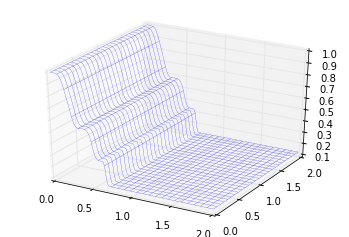

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')
bla = MUSCL_Hancock(U,dx,dy,0.2,C=0.6,Riemann = "HLLC",beta=Beta)
#surf = ax.plot_surface(xx, yy, bla[Id_rho], cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)
ax.plot_wireframe(xx, yy, bla[Id_rho], rstride=4, cstride=4,linewidth=0.2)
#fig.colorbar(surf, shrink=0.5, aspect=5)

In [18]:
U = setInitShockX(xx,yy,np.zeros((4,Nx,Ny)))
blaX = MUSCL_Hancock(U,dx,dy,Tend,C=0.6,Riemann = "HLL",beta=Beta)
blubX = MUSCL_Hancock(U,dx,dy,Tend,C=0.6,Riemann = "HLLC",beta=Beta)

done in 56 steps
done in 56 steps


done in 60 steps


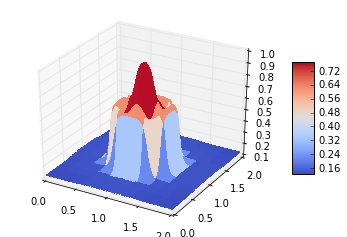

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')
U = setInitExpl(xx,yy,np.zeros((4,Nx,Ny)))
bla = MUSCL_Hancock(U,dx,dy,Tend,C=0.6,Riemann = "HLL",beta=Beta)
surf = ax.plot_surface(xx, yy, bla[Id_rho], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.plot_wireframe(xx, yy, bla[Id_rho], rstride=4, cstride=4,linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)